# INFO 3350/6350

## Lecture 12: Neural networks

## Neural networks and deep learning

* We've used NLP tools at many points this semester, but this isn't an NLP class
* That said, neural methods have transformed many areas of NLP over the last decade
    * And deep learning -- a subset of neural methods -- has been very widely applied in machine learning and AI
* Our tasks today: define "neural network," relate neural nets to other learning systems, take a look at how a neural network works, and show how to implement a very simple neural classifier in Python

### What is a neural network?

* A neural network is a computing system comprising artificial neurons
* Neurons were originally (1940s) intended to model organic brain behavior
    * But now, the name is really just a bit of jargon. No one thinks its important whether or not computational neurons have anything to do with biological neurons.
* Individual neurons are mathematical functions that take a vector of input values and produce a single output value.
    * We've seen lots of these kinds of functions over the semester, not all of them related to actually existing neural networks
    * What matters are the details of the functions and the ways they relate to one another in a network
* In a neural network, the neurons are connected to one another in one or more layers, so that the output of one neuron is the input of another (or many others)
    
### Logistic regression

* Logistic regression **is not a neural network** in the modern sense, but it captures much of the spirit of a basic neural network and a lot of the math is related, so let's revisit it
* Fit training data to a linear model: $z = W_0 + W_1 x_1 + W_2 x_2 + ...$
    * Values of $x\ $ are observed properties of an object (counts of individual words, say)
    * The $W\ $ s are weights. We multiply the weight associated with each word (for example) by the number of times that word occurs in a document.
        * These types of element-wise multiplications between two vectors are called **dot products**
    * Add up the weight * count products and we produce an output value, $z$
    * Note that values of $z$ can range from -infinity to +infinity
* Transform the linear value into a score between 0 and 1 using the sigmoid function: $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
* Sigmoid function looks like this:
    
<img src="./images/sigmoid.png">

* When we train a logistic regression classifier, we're trying to learn the set of weights that produce the most accurate classifications
* We learn the weights by:
    * Initializing to random values (or equal values, or some arrangement that reflects our best guess about the correct weights)
    * Calculating **cross-entropy loss**, that is, how far away are our predicted outputs from the known-true (gold) values.
        * Our goal is to minimize this loss function by adjusting the weights in our model
        * See Jurafsky and Martin, ch. 5 ("Logistic Regression"), for the math, but the short version is that we take (roughly) the negative log of the sum of the differences between the predicted labels (as probabilities ranging from 0 to 1) and the true labels (which are either 0 or 1)
        * Trivia point: logistic regression is a more advanced version of the **perceptron** (which uses a binary loss function rather than a probabilistic one). The perceptron was invented at Cornell (by Frank Rosenblatt in 1958).
    * Adjusting our weights using **gradient descent**
        * Again, the math isn't important to us, but ... we find the gradient (slope) of the loss function by partial differentiation with respect to each of the weights. In short, we find how the loss function chages in response to small changes in each weight, then move the weight in the direction that minimizes the loss. Repeat until the loss function stops changing (much) and hope we've found the global minimum (that is, the globally best weights).
* If you've been around neural networks and machine learning, these terms will sound familiar: loss function, gradient descent. Now you know what they mean.

### From logistic regression to feed-forward networks

* The problem with logistic regression (which is a great classifier for many problems!) is that it can only learn linear relationships between inputs and outputs. If our problem is nonlinear, logistic regression might not work well on it.
* The simplest way to understand the relationship between logistic regression and a basic neural network is that a neural network is made up of multiple logistic-like functions, each of which can learn a different part of the correct solution (where "solution" = function that best fits the training data)
* Here's a schematic representation (from Jurafsky and Martin) of a feed-forward network with a single hidden layer (the middle one, with labels $h_i$):

<img src="./images/neural_network.png">

* There are three layers here: input, hidden, and output.
    * The input layer is the data you feed into the system.
    * The hidden layer is where the weights are adjusted to maximize classification accuracy. This is what *learns*.
    * The output layer translates numerical values calculated in the hidden layer into class probabilities (that is, into specific classification decisions).
* The math in this case is the same as in the logistic case, except that:
    * We have matrices of weights across the neurons, rather than a single vector of weights for a single neuron
    * We have a vector of outputs from the hidden layer, rather a single, scalar output
    * Gradient descent is harder, because there are more paths to differentiate
        * This is the most consequential difference in practical terms, because it really slows down training
        * The standard approach is **backpropagation**. For details, See Jurafsky and Martin, ch. 7 ("Neural Networks"). It's like partial differentiation, but performed piece-wise backward through the all the possible paths from outputs to inputs via the hidden layer(s). 
        
### From shallow to deep

* Even a neural network with a single hidden layer (of possibly infinite width; that is, made up of arbitrarily many neurons) can be shown to be able to represent a function of arbitrary complexity
    * Note in passing: this is a remarkable result. It means that neural networks are immensely flexible in the relationships between inputs and outputs that they can model.
    * But this fact doesn't imply that it's *easy* to learn a correct or high-performing representation of an arbitrary function in a neural network
* In practice, it can be (sometimes!) more efficient to build networks that are narrower but *deeper*; that have more layers
* Deep learning also largely removes the need for (certain kinds of) feature engineering, since the layers learn maximally effective transformations of the data
    * But the right kinds of data still need to be present in the first place!
    * If you only give your network word counts, it won't magically engineer paratextual features.
* You may have heard of **convolutional** neural networks and **recurrent** neural networks. These are networks in which there is not a strict one-to-one connection between all the neurons in each layer.
    * Convolutional networks are (or, were) widely used in image recognition
    * Recurrent networks (in which parts of layers are connected both forward and backward) are (again, were) often used in NLP applications
* All of this is **slow** and involves a lot of matrix math. Two main factors have driven the deep learning revolution over the last two decades:
    * Web-scale data, which provides enough instances to learn fine distinctions in complex decision boundaries
        * A method that can model arbitrarily complex functions isn't much good if you don't have enough data to explore the function space
    * GPUs (graphics cards), which are essentially super-fast matrix calculators
        * These make computing with all that data tractable (more or less)
* More recently, we've discovered that we can do without recurrence or convolution, provided we have enough data. This is the insight behind the transformer architecture, BERT, and all that has followed. We'll have more to say about that in future lectures. 

## Basic neural network classification in `torch`

Again, this isn't an actual ML or NLP course. However, since today's language models are often PyTorch models under the hood, it's good to have a high-level understanding of how PyTorch works. Building an MLP is a great way to get comfortable with the "building blocks" of neural networks using this library.

We won't be focussing on our results too much (we're running this live in class, after all). Instead, try to focus on what each part of the code is doing, given the preceding introduction.

In [3]:
import torch
from torch import nn    
from torch.nn import functional as F    # This is the "numpy as np" of torch, so to speak

PyTorch makes building neural nets very easy, since we don't have to keep track of weights and gradients ourselves. For instance: 

In [4]:
linear_layer = nn.Linear(128, 32) # (input_dim, output_dim)

print("Layer weight matrix: ", linear_layer.weight.shape)
print("Layer bias vector: ", linear_layer.bias.shape)  

Layer weight matrix:  torch.Size([32, 128])
Layer bias vector:  torch.Size([32])


Recall that a layer in an MLP has the form $$y=\sigma(xW^T + b)$$ where $x$ is our input, $W$ is our weight matrix, $b$ is our bias vector, and $\sigma$ is our activation function. This `nn.Linear` takes care of our $W$ and $b$ for us. 

In [5]:
random_input = torch.randn((5, 128))
layer_output = linear_layer(random_input)

print(layer_output[0])
print(layer_output.shape)
print("Requires grad?", layer_output.requires_grad)
print("Max: ", layer_output.max())
print("Min: ", layer_output.min())

tensor([-0.7018,  0.4108,  0.1057, -0.4428, -0.1365, -0.9067,  0.0938,  0.0203,
         0.4078, -0.4836,  0.2091,  0.8099, -0.2679, -0.2801, -0.0483, -0.8730,
         0.1560, -0.1477, -0.5156, -0.5034,  1.0639, -0.7810, -0.9566,  0.4746,
        -1.0741, -0.2438,  0.1191, -0.8212, -0.3253,  0.0122,  0.0969,  0.1733],
       grad_fn=<SelectBackward0>)
torch.Size([5, 32])
Requires grad? True
Max:  tensor(1.4688, grad_fn=<MaxBackward1>)
Min:  tensor(-1.4006, grad_fn=<MinBackward1>)


Above, we can see that our linear layer handles the $xW^T + b$ for us. 

We can also see that `torch` will "keep track" of gradients for us, unless we tell it otherwise. This is important for training, but when evaluating or running our model after it is trained, we don't need gradients to be computed. We can turn off autograd using a context manager like so:

In [6]:
with torch.no_grad():    
    random_input = torch.randn((5, 128))
    layer_output = linear_layer(random_input)
    print(layer_output[0])
    print("Requires grad?", layer_output.requires_grad)

tensor([-0.3083,  0.2552, -0.0056, -0.3120, -0.5979, -1.2972, -0.1849, -0.0836,
         1.8068,  0.4168,  0.5786,  0.0855,  0.5496, -0.2219, -0.3818, -1.6394,
         0.6022,  1.1264, -0.0752, -0.4198,  0.2587,  0.9473,  0.2984, -1.2766,
        -0.8682,  0.6112, -0.4562, -0.4195, -1.0250, -0.8220,  0.2453,  0.0118])
Requires grad? False


This will be important later!

Our `Linear` layer handles the weights and bias term, but we still need an activation function to build a real MLP. PyTorch has a bunch of built-in activation functions, which can be treated as a layer:

In [7]:
sigma = nn.Sigmoid()

with torch.no_grad(): 
    sigmoid_output = sigma(layer_output)

sig_max = sigmoid_output.max()
sig_min = sigmoid_output.min()

print(f"Max: {sig_max}\nMin: {sig_min}")

Max: 0.8589800000190735
Min: 0.1625528186559677


or a function:

In [8]:
with torch.no_grad():
    f_sig_output = F.sigmoid(layer_output)

assert torch.allclose(sigmoid_output, f_sig_output)

One reason to use `nn.Sigmoid` over `F.sigmoid` is illustrated below:  


In [9]:
stack_of_layers = nn.Sequential(
    nn.Linear(32, 64),
    nn.ReLU(),      # Rectified linear unit (another act. fn.)
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)

with torch.no_grad():
    stack_output = stack_of_layers(torch.randn((32)))

stack_output

tensor([0.4971])

That `stack_of_layers` is an MLP! `nn.Sequential` takes a sequence of layers (more specifically, PyTorch objects that subclass `nn.Module`) and chains them together.  

In [10]:
stack_of_layers

Sequential(
  (0): Linear(in_features=32, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
  (5): Sigmoid()
)

So while we could build an MLP using `nn.Sequential`, you could (and probably should) define your model as a subclass of `nn.Module`. Subclasses of `nn.Module` must override the `__init__` and `forward` methods. This makes sense, since `__init__` initializes our model with some layers, and `forward` defines how data moves through those layers.

In [21]:
class MyFirstMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim) # Layer 1
        self.fc_2 = nn.Linear(hidden_dim, 1) # Layer 2

    def forward(self, x):
        h = F.relu(self.fc_1(x))          # h = ReLU(xW1_T + b)
        return F.sigmoid(self.fc_2(h))    # y_hat = Sigmoid(hW2_T + b)


That's it! 

We could also do something like this: 

In [22]:
# Reusing modules, using nn.Sequential inside a module, and 
# passing functions around...

class MLPLayer(nn.Module):
    def __init__(self, input_dim, output_dim, act_fn): 
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.act_fn = act_fn
    
    def forward(self, x): 
        return self.act_fn(self.fc(x))


class MLPBinaryClassifier(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 num_hidden_layers, 
                 act_fn=F.relu):
        super().__init__()
        
        self.net = nn.Sequential(
            MLPLayer(input_dim, hidden_dim, act_fn),
            *[MLPLayer(hidden_dim, hidden_dim, act_fn)
              for _ in range(num_hidden_layers)]
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.net(x)
        return self.head(h)

Homework hint: you should look at the non-linear activation functions in the [PyTorch documentation](https://docs.pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).

### Training a model
Let's go back to looking at author gender in our `/texts`. We're going to actually train our `MLPBinaryClassifier` on tf-idf vectors created from novel chunks. 

We aren't going to focus too much here on our accuracy. 

In [11]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import re
import os

In [12]:
# Remember this from Lecture 9.5?

root_dir = "../data/texts"

book_paths = os.listdir("../data/texts")

def get_txt_file(path):
    with open(path, "r") as f:
        file = f.read()
    return file

texts = [get_txt_file(os.path.join(root_dir, p))
         for p in book_paths]

pattern = re.compile(r"^[ABFO]-(.+)-(.+)-(\d{4})-([FM]).txt$")

columns = ["path", "author", "title", "year", "gender", "text"]

parsed_metadata = [[p] + list(re.search(pattern, p).groups()) + [texts[i]]
                   for i, p in enumerate(book_paths)]

df = pd.DataFrame(parsed_metadata, columns=columns)

df["text"] = df["text"].apply(lambda x: re.split(r"\n+\s*\n*", x))
df["year"] = df.year.astype(int)

df = df.explode("text")

df["wc"] = df.text.apply(lambda x: len(x.split()))

min_length, max_length = (25, 1000) # Filter by length of text

df = df[(df["wc"] > min_length) & (df["wc"] < max_length)]

df

,path,author,title,year,gender,text,wc
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,1801.--I have just returned from a visit to my...,115
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"'Mr. Lockwood, your new tenant, sir. I do mys...",48
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,"The 'walk in' was uttered with closed teeth, a...",54
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,When he saw my horse's breast fairly pushing t...,42
0,B-Bronte_E-Wuthering_Heights-1847-F.txt,Bronte_E,Wuthering_Heights,1847,F,'Here we have the whole establishment of domes...,33
...,...,...,...,...,...,...,...
40,A-Norris-Pit-1903-M.txt,Norris,Pit,1903,M,"For a moment, vague, dark perplexities assaile...",55
40,A-Norris-Pit-1903-M.txt,Norris,Pit,1903,M,"She did not know. But as she searched, trouble...",45
40,A-Norris-Pit-1903-M.txt,Norris,Pit,1903,M,"She looked out quickly, on either hand, throug...",52
40,A-Norris-Pit-1903-M.txt,Norris,Pit,1903,M,"All at once, intuitively, Laura turned in her ...",94


In [13]:
df.gender.value_counts()

gender
M    27679
F    26396
Name: count, dtype: int64

In [14]:
vectorizer = TfidfVectorizer(
    max_features=256  # Limit dimensionality of our X.
)                     # These features won't be great, but 
                      # they'll be useful for a demonstration.

X_tfidf = vectorizer.fit_transform(df.text)
y = df.gender.to_numpy() == "M"

In [15]:
X_tfidf.shape

(54075, 256)

Make a train-test split. In reality, we'd want to split into train, test, and eval sets. While training, we'd evaluate on eval, then evaluate on test only after we're done training. We're simplifying things here.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf.astype(np.float32), y.astype(np.float32), train_size=0.8
)

### Baseline

First, score a simple logisitic regression classifier on word embedding data. This is **not** a neural classifier. We'll use it as a baseline.

In [18]:
lrc = LogisticRegression().fit(X_train, y_train)
lr_baseline = lrc.score(X_test, y_test)
print("Test accuracy: ", lr_baseline) 
print("Majority Baseline: ", y_test.sum()/y_test.shape[0])

Test accuracy:  0.640499306518724
Majority Baseline:  0.5101248


### PyTorch training loop

You don't need to understand what's going on here in detail. A vibe-level understanding of the training loop is fine. Pay more attention to what's going on in `eval_model`. 

In [19]:
def eval_model(model, X, y, device, batch_size=100):
    y_hats = []
    model.eval() # Put model in eval mode
    for i in range(0, X.shape[0], batch_size):
        with torch.no_grad(): # Don't need gradients
            x_batch = torch.tensor(X[i:i+batch_size].todense()).to(device)
            y_hat = model(x_batch).cpu().squeeze().numpy()
            y_hats.append(y_hat)
    y_hats = np.concat(y_hats) >= .5
    return accuracy_score(y.astype(bool), y_hats)

def train_model(model, X_train, y_train, X_test, y_test, 
                num_epochs=5, batch_size=100, lr=1e-3, verbose=True):
    """
    Args:
        model: Our MLP
        X_train, X_test: Sparse matrices of tf-idf values (train, test)
        y_train, y_test: binary labels (train, test)
        num_epochs: Number of epochs (times we train on all of our train data)
        batch_size: Number of samples per training step
        lr: Learning rate (hyperparameter for the optimizer, basically how much we update
            model params per step)
        
    """
    device = "cuda" if torch.cuda.is_available else "cpu"
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    
    model.to(device)    # Move the model to GPU if we have one
    for epoch in range(num_epochs):  
        # Training
        model.train()   # Put model in training mode
        for i in range(0, X_train.shape[0], batch_size):
            optimizer.zero_grad()   # Zero gradients every training step

            x_batch = torch.tensor( # Convert our Xs and ys to Tensors on the right device
                X_train[i:i+batch_size].todense()
            ).to(device)
            y_batch = torch.tensor(y_train[i:i+batch_size]).to(device)    

            y_hat = model(x_batch)  # Get our model output

            loss = F.binary_cross_entropy(y_hat.squeeze(), y_batch) # Compute loss

            loss.backward() # Backprop

            optimizer.step()
        
        # Evaluation
        if verbose:
            acc = eval_model(
                model, X_test, y_test, device, batch_size=batch_size
            )
            print(f"Epoch {epoch}:\n\tLast step loss: {loss.item()}\n\tEval acc: {acc}")
        elif epoch + 1 == num_epochs:
            acc = eval_model(
                model, X_test, y_test, device, batch_size=batch_size
            )

    return acc 

### MLP Training

Finally, let's train both our simple, `MyFirstMLP` model as well as an MLP with many more layers. What do you expect will happen?

In [25]:
simple_mlp = MyFirstMLP(X_train.shape[-1], 32)

train_model(simple_mlp, X_train, y_train, X_test, y_test, num_epochs=10)

Epoch 0:
	Last step loss: 0.6617153286933899
	Eval acc: 0.6378178455848359
Epoch 1:
	Last step loss: 0.6498311161994934
	Eval acc: 0.6408691631992602
Epoch 2:
	Last step loss: 0.6452489495277405
	Eval acc: 0.6420711974110033
Epoch 3:
	Last step loss: 0.6434369683265686
	Eval acc: 0.6426259824318077
Epoch 4:
	Last step loss: 0.6400379538536072
	Eval acc: 0.6462320850670366
Epoch 5:
	Last step loss: 0.6353148818016052
	Eval acc: 0.6471567267683772
Epoch 6:
	Last step loss: 0.6284622550010681
	Eval acc: 0.6483587609801202
Epoch 7:
	Last step loss: 0.6220479607582092
	Eval acc: 0.6515950069348128
Epoch 8:
	Last step loss: 0.6145092248916626
	Eval acc: 0.6549237170596394
Epoch 9:
	Last step loss: 0.6076176166534424
	Eval acc: 0.6588996763754046


0.6588996763754046

In [26]:
lr_baseline

0.640499306518724

In [27]:
big_mlp = MLPBinaryClassifier(X_train.shape[-1], 32, 5)

train_model(big_mlp, X_train, y_train, X_test, y_test)

Epoch 0:
	Last step loss: 0.6628468036651611
	Eval acc: 0.6388349514563106
Epoch 1:
	Last step loss: 0.6492152214050293
	Eval acc: 0.6431807674526121
Epoch 2:
	Last step loss: 0.6348750591278076
	Eval acc: 0.6560332871012483
Epoch 3:
	Last step loss: 0.5980568528175354
	Eval acc: 0.664447526583449
Epoch 4:
	Last step loss: 0.550435483455658
	Eval acc: 0.6688858067498844


0.6688858067498844

Though we've been holding learning rate and batch size constant, these are important hyperparameters that can have a significant impact on the training and performance of your model. Let's look at our simple MLP again and see how these hyperparameters impact our accuracy score. 

In [28]:
batch_sizes = [50, 100, 200]
lrs = [5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]

results = np.zeros((len(lrs), len(batch_sizes)))
for i, lr in enumerate(lrs):
    for j, bsz in enumerate(batch_sizes):
        model = MyFirstMLP(X_train.shape[-1], 64)
        acc = train_model(
            model, X_train, y_train, X_test, y_test, 
            lr=lr, batch_size=bsz, verbose=False
        )
        results[i, j] = acc

<Axes: >

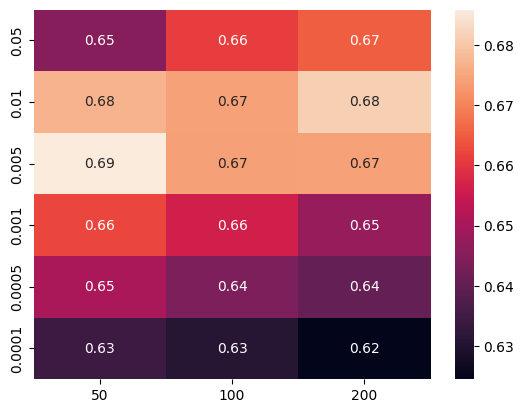

In [29]:
sns.heatmap(
    data=results,
    xticklabels=batch_sizes,
    yticklabels=lrs, 
    annot=True
)

What does this suggest about the relationship between learning rate and batch size for our data?